This document shows how to use this `nevis`-based optimiser benchmarking framework.

## Defining a new algorithm

Some examples can be found in the `./algorithm` directory. Take Dual Annealing (`./algorithm/dual_annealing.py`) as an example.

We define a function with following signature, decorated by `@optimizer`:

```python
def run_dual_annealing(
    f, 
    x_max, 
    y_max, 
    rand_seed, 
    init_guess, 
    trial: optuna.Trial,
    get_budget,
):
```

where 
- `f` is a function that takes a tuple of coordinates in metres and returns its **negative** height (and thus should be minimised). Optionally, you can pass a `grad` argument to `f`, which should be an `numpy` array of size `2` and is modified in place to be the gradient of the function at the given coordinate (as one would do in `nlopt`);
- `x_max` and `y_max` define the boundary of the problem, which is `[0, x_max] × [0, y_max]`;
- `rand_seed` defines the random seed for the run. It should be used in places like `np.random.seed(rand_seed)` or passed to the optimiser if applicable (such as in this case the `seed` argument of `scipy.optimize.dual_annealing`);
- `init_guess` defines the initial guess for the run. It should be passed to the optimiser (such as in this case the `x0` argument of `scipy.optimize.dual_annealing`);
- `trial` is an instance of `optuna.Trial` and is used for defining hyper-parameters. See [here](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html) for more;
- `get_budget` is a function that takes no arguments and returns the remaining number of function evaluations for the current run. 

The function `run_dual_annealing` should return a dictionary of the following form:

```python
{
    'x': (x_best, y_best), # coordinates of the minimum returned by the optimiser
    'z': z_best, # minimum returned by the optimiser
    'message': 'A message of why the run terminated', # optional
    'trajectory': [(x, y), ...], # optional
}
```

The decorator `@optimiser` records every function call to `f` and ensures that as our optimiser calls `f`, the number returned by `get_budget` reduces accordingly. The decorated function returns a `Result` object that contains all information related to the run and its result.

Then we define an algorithm instance using the function `run_dual_annealing`:

```python
dual_annealing = Algorithm(
    name='Dual Annealing',
    func=run_dual_annealing,
    version=3
)
```

where `name` is the name of the algorithm and `version` is an integer. It is intended that you change the `version` number when you modify the body of `func` (i.e. when you change how the algorithm works), so that results are recorded separately for different versions of the algorithm.

## Defining some constants
Check `config.py` for constants defined in the framework. It is assumed that these values are unchanged throughout the usage; otherwise, data stored would be inconsistent.

## `Result` class explained

Each time an algorithm instance is run, we get a `Result` object. This object records the following data:

```
'algorithm_name'
'algorithm_version'
'instance_index'
'result_index'

'info' # a dict that contains above four keys

'ret_point' # returned point (x, y) tuple of floats
'ret_height' # returned height, float
'message' # string

'points' # a list of all the evaluated points during this run
```

Based on the list of `points`, the following data is calculated:

```
'is_success' # bool
'eval_num' # number of function evaluations 
'gary_score' # gary score obtained
'len_points' # length of returned points
```

Basically, we try to find the point with the maximum height in the first `MAX_FES` evluations of `points`. If there is one such evaluation that is higher than `SUCCESS_HEIGHT`, then this run is successful and `eval_num` is the index of the first such evaluation. If all considered evaluations are not higher than `SUCCESS_HEIGHT` then the highest one is picked for calculating the `gary_score` for this run. These three values are used for calculating the performance measures of an algorithm instance. 

`len_points` is simply the length of the `points` list: this is not used in calculating performance measures of an algorithm instance; in fact, it can sometimes exceed `MAX_FES` as some algorithms do not obey this termination criteria strictly. `len_points` is recorded mainly to identify if a run was terminated early on its own (like what local optimisers do).

Note that the height we use to determine `is_success` and `gary_score` is restricted to the first `MAX_FES` ones in `points`. It is theoretically possible that this height is not the same as `ret_height`, which is the height returned by the optimiser, if the optimiser does not obey `MAX_FES` strictly and `ret_height` is discovered after `MAX_FES` evaluations. However, this height we actually use is not currently recorded.

## How the data is saved

`optuna`, our hyper-parameter tuning framework, saves the data for each algorithm instance that is generated, including the hyper-parameter used and the performance measure (GERT).

On the other hand, the data regarding each run of any given algorithm instance is saved using the `SaveHandler` class. This can be either a `SaveHandlerMongo` (using `MongoDB`) or a `SaveHandlerJSON` (using `JSON` files under a given directory). 

When we save a run result, the following data is always saved:
```
'algorithm_name'
'algorithm_version'
'instance_index'
'result_index'
'info' 
'ret_point' 
'ret_height' 
'message' 
'is_success' 
'eval_num'
'len_points'
'gary_score' 

```

In addition, a run can be saved with `points`. In this case this run is saved in 'full'; otherwise, it is 'partially' saved. In theory, since the random seed and initial guess are determined by `result_index`, even if we only save the result partially, we could recover the evaluated points just by running it again.



## An actual example

Let's use the predefined Dual Annealing as an actual example. 

[I 2023-10-05 12:01:59,361] A new study created in RDB with name: Dual Annealing-3
1026375it [00:43, 23860.95it/s]                            
[I 2023-10-05 12:02:52,878] Trial 0 finished with value: 17696.120689655174 and parameters: {'initial_temp': 142.4636524588688, 'restart_temp_ratio': 0.0003574646093760913, 'visit': 2.681037479625761, 'accept': -3.4012573439860265}. Best is trial 0 with value: 17696.120689655174.
1000039it [00:42, 23751.72it/s]                            
[I 2023-10-05 12:03:44,162] Trial 1 finished with value: 71431.35714285714 and parameters: {'initial_temp': 837.8640930185429, 'restart_temp_ratio': 0.002175456284503398, 'visit': 1.9755168455176246, 'accept': -3.1868319820779742}. Best is trial 0 with value: 17696.120689655174.
1036419it [00:43, 23593.33it/s]                            
[I 2023-10-05 12:04:37,697] Trial 2 finished with value: 6397.648148148148 and parameters: {'initial_temp': 7291.680920444876, 'restart_temp_ratio': 0.001085580709061958, 'visi

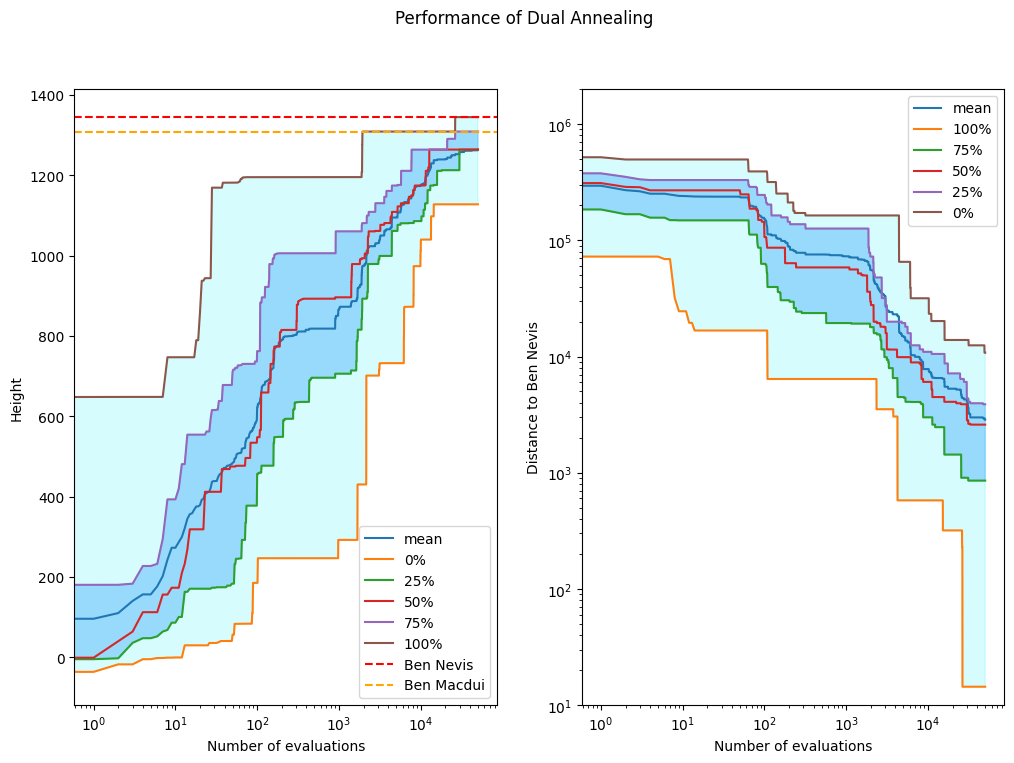

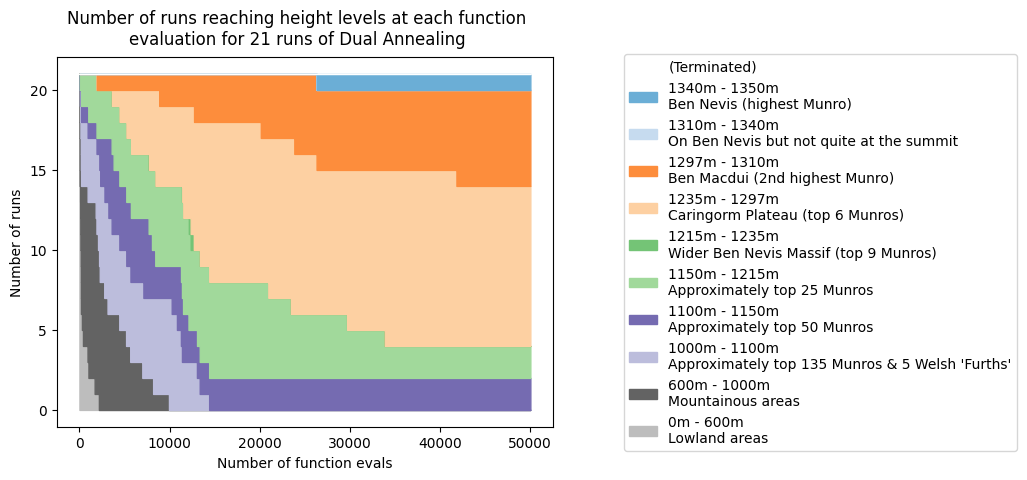

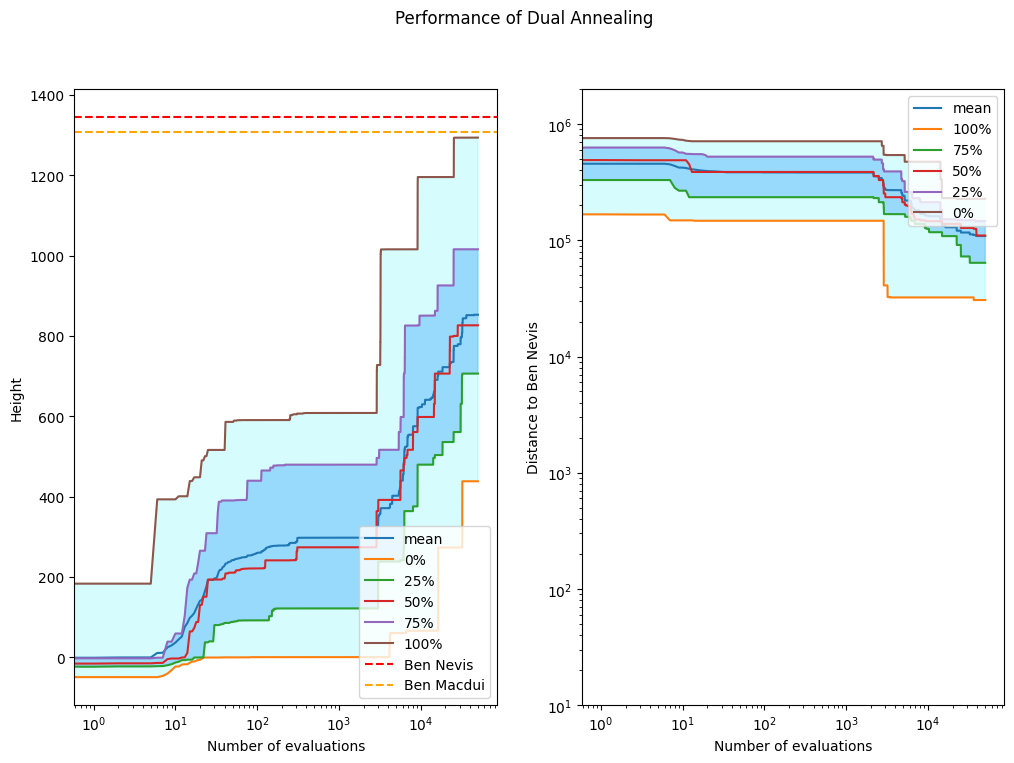

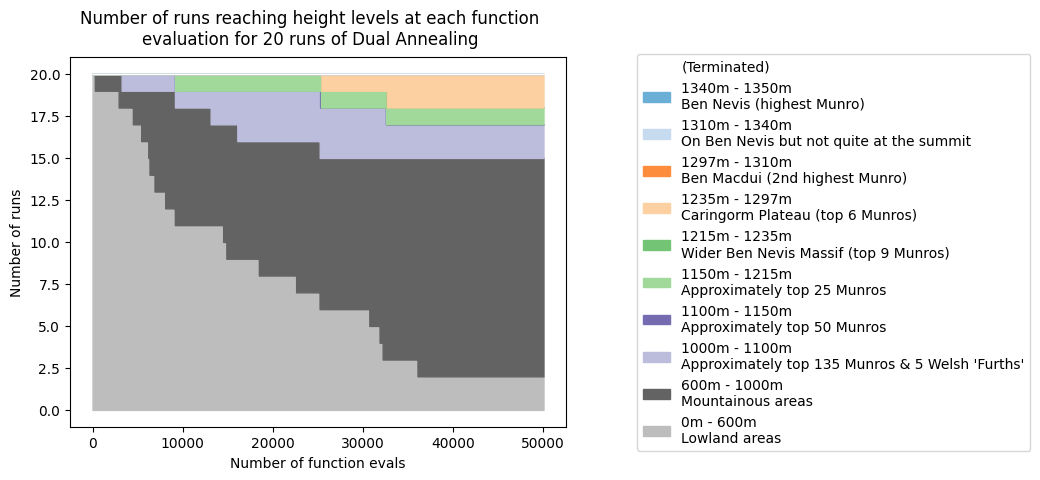

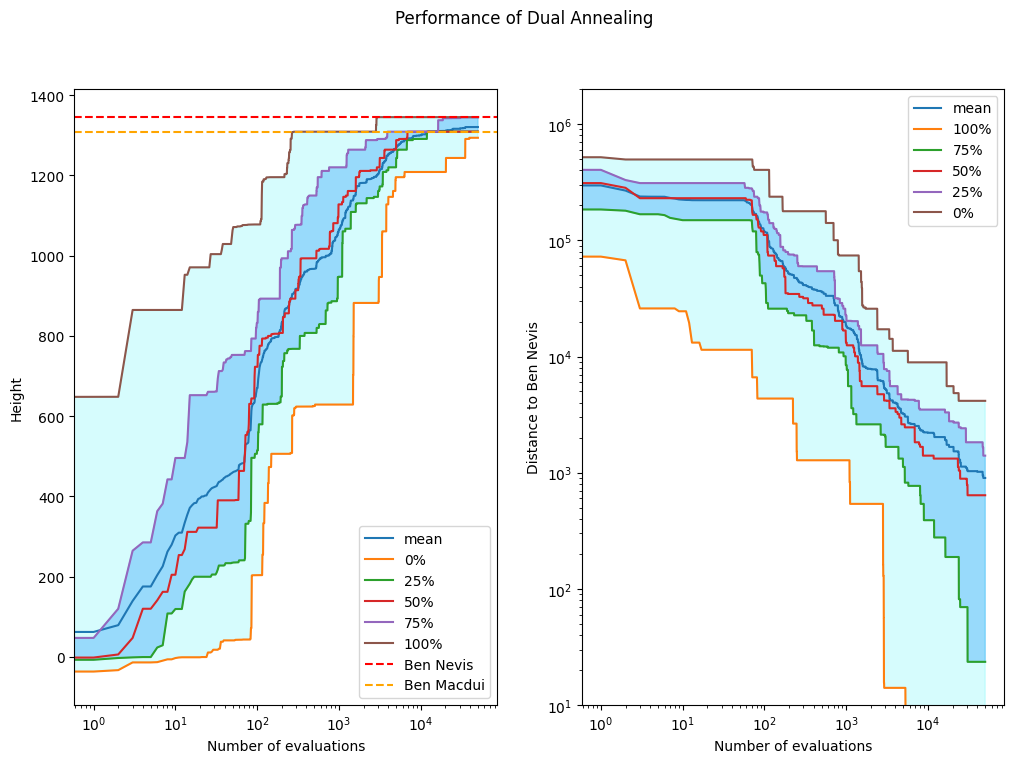

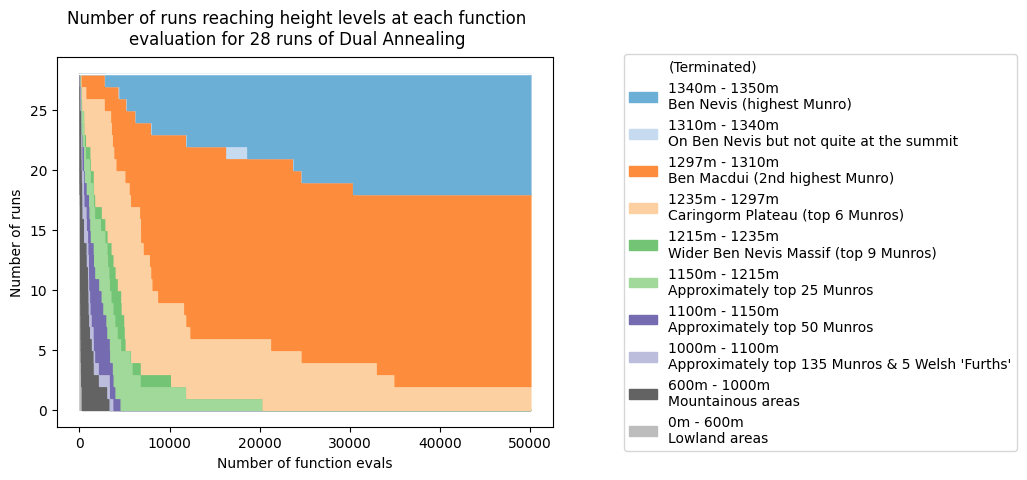

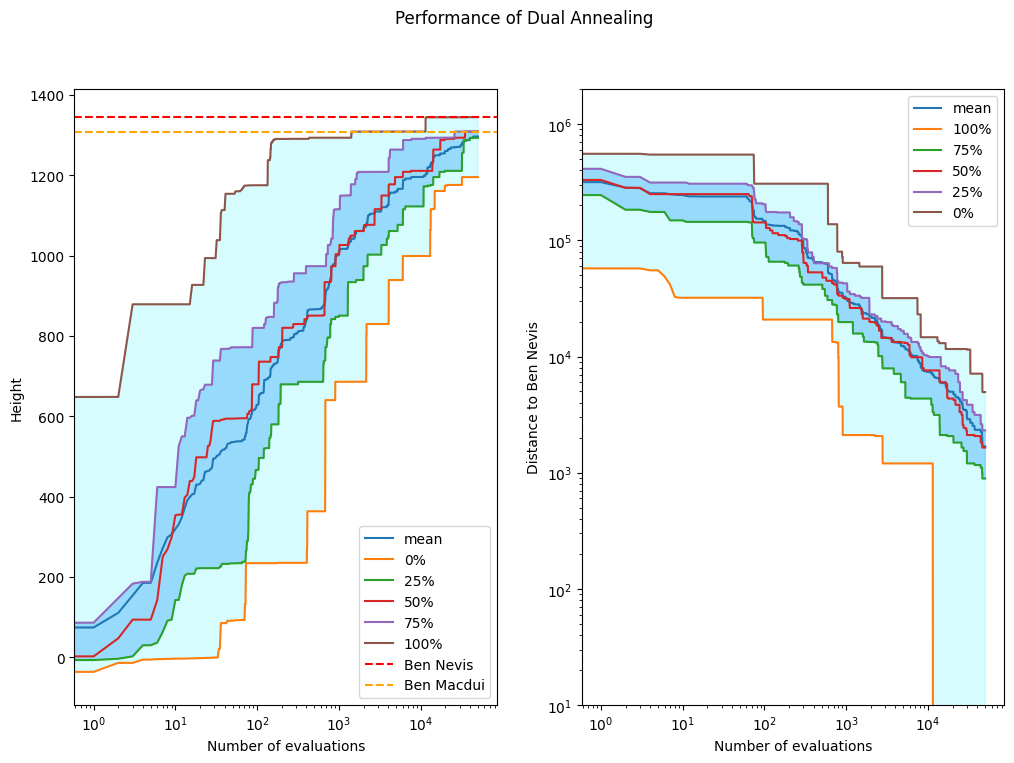

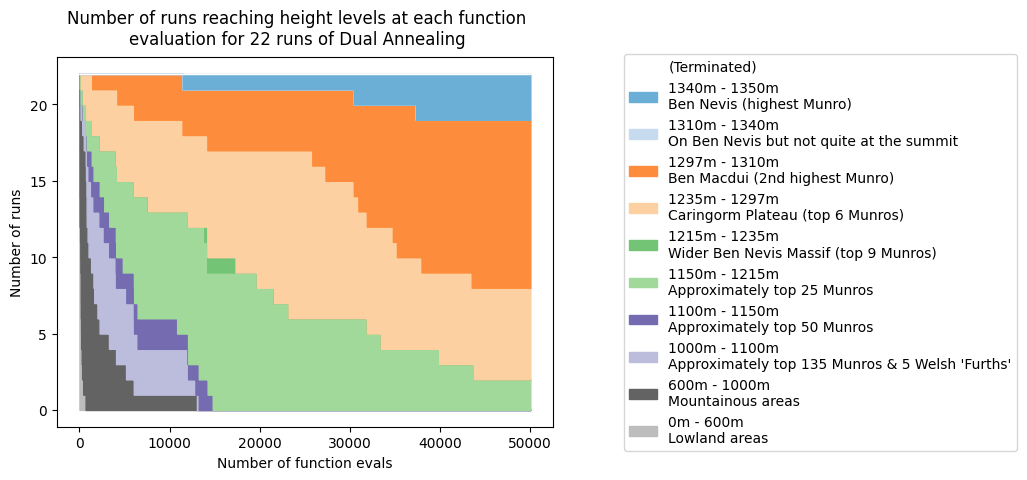

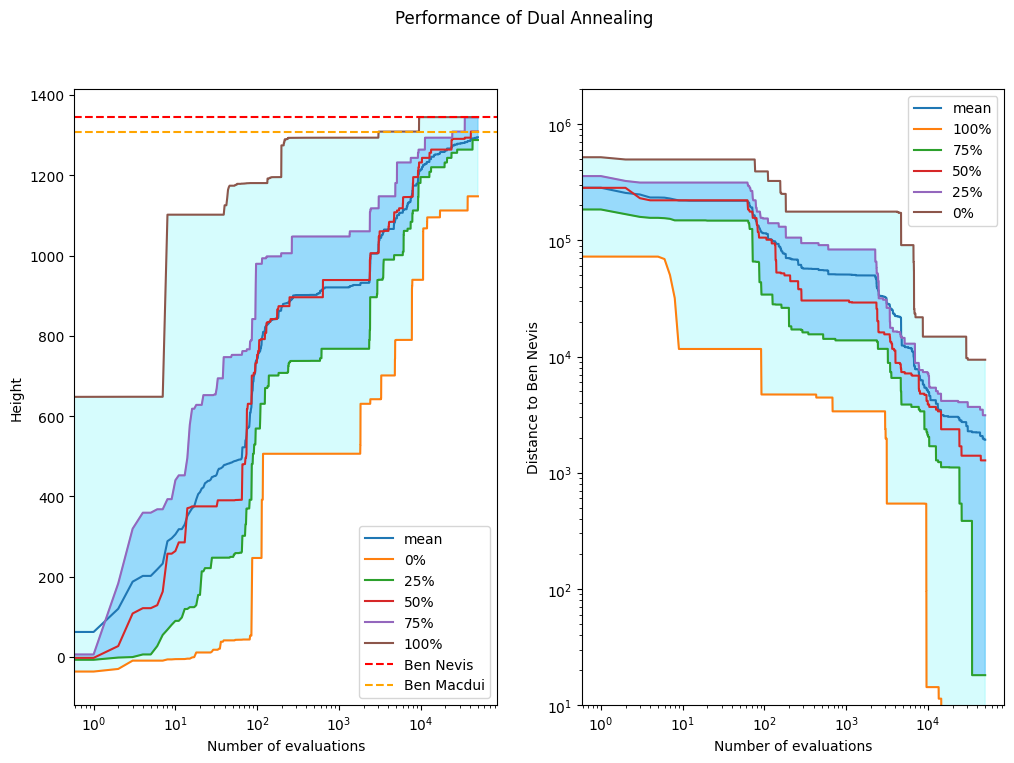

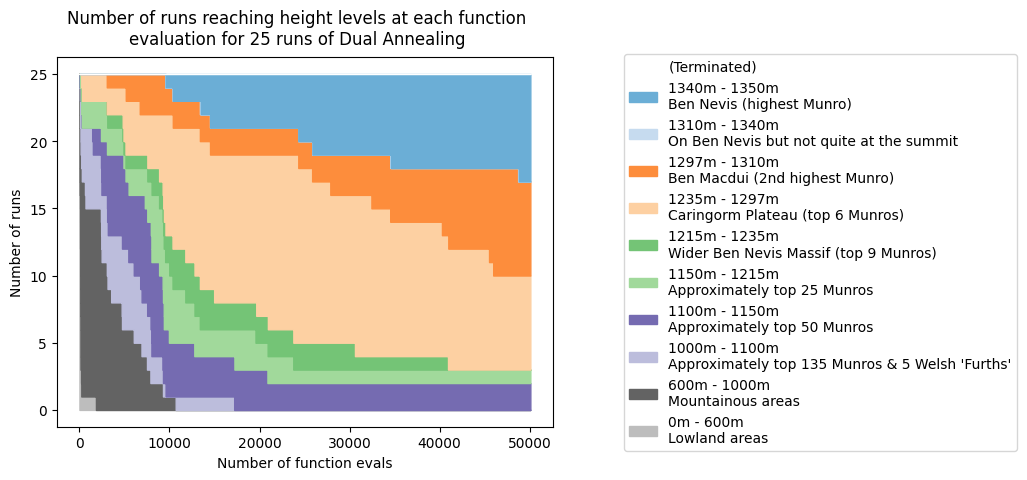

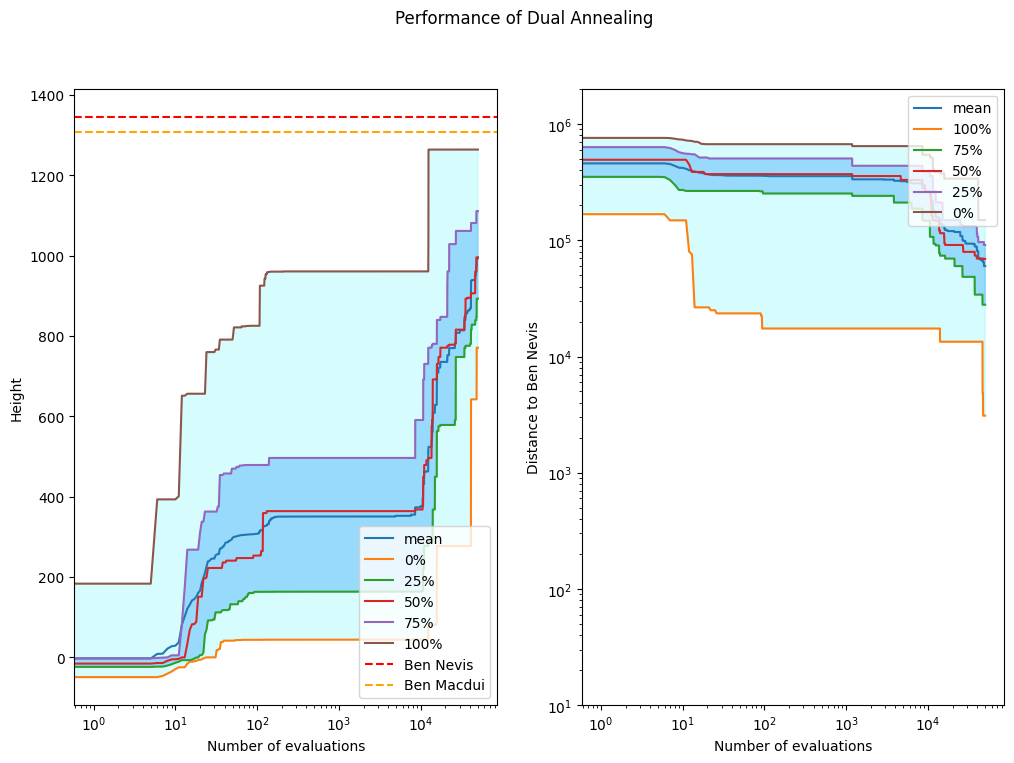

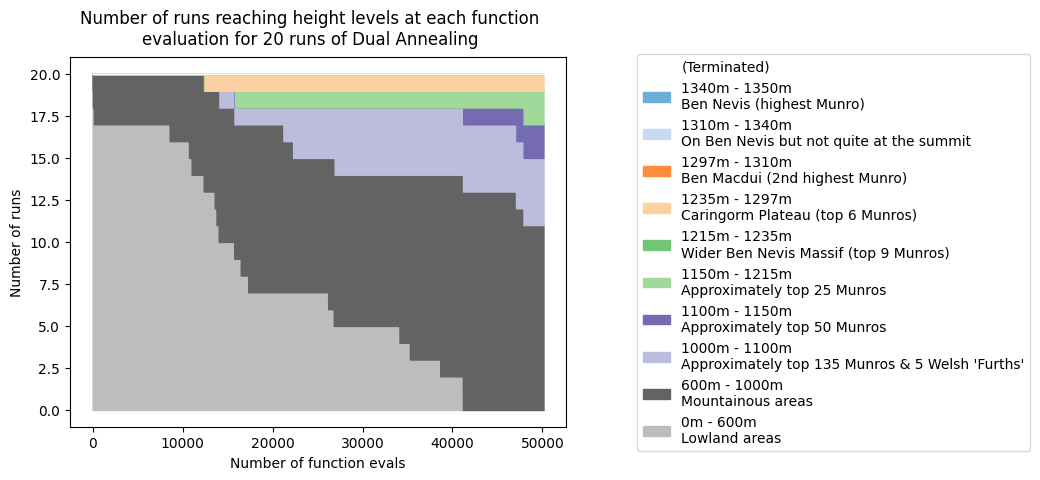

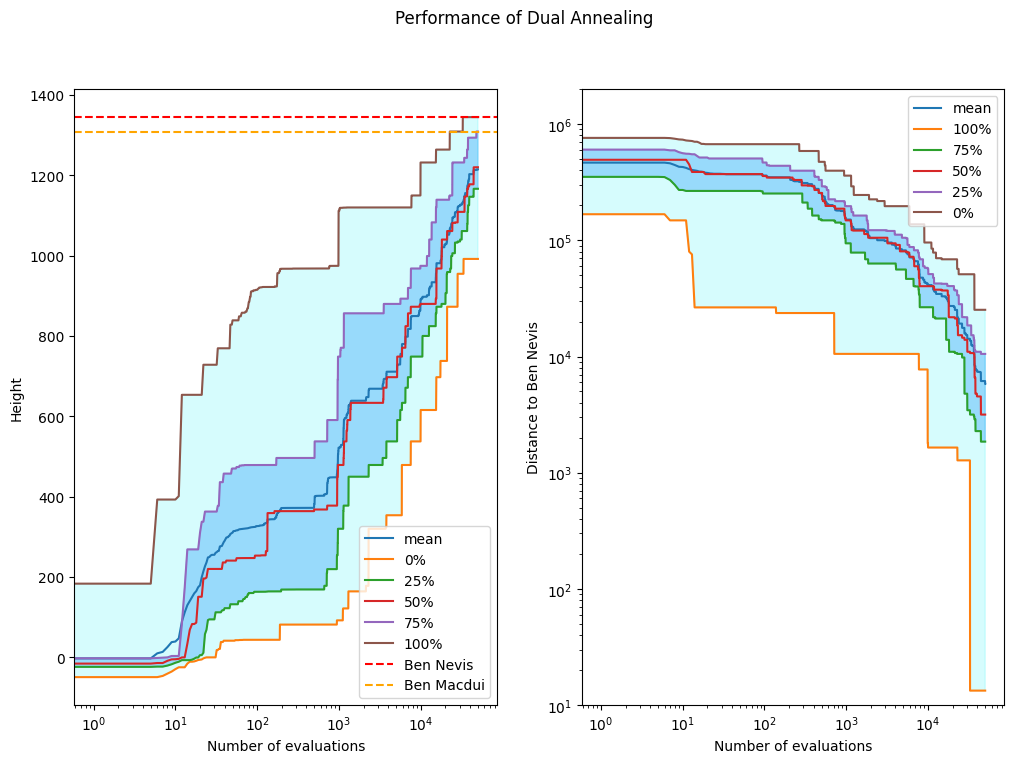

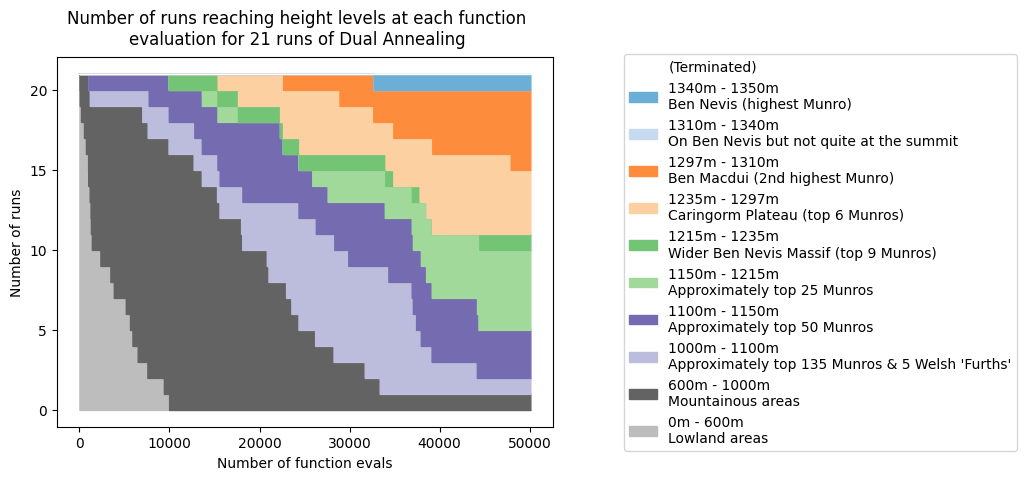

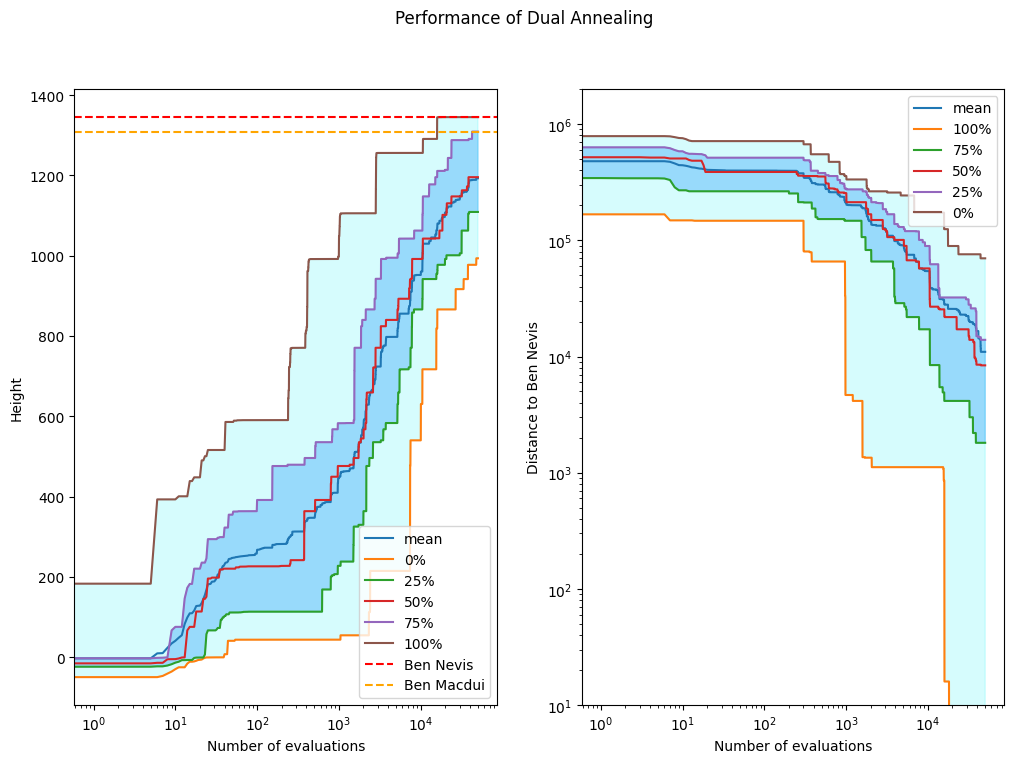

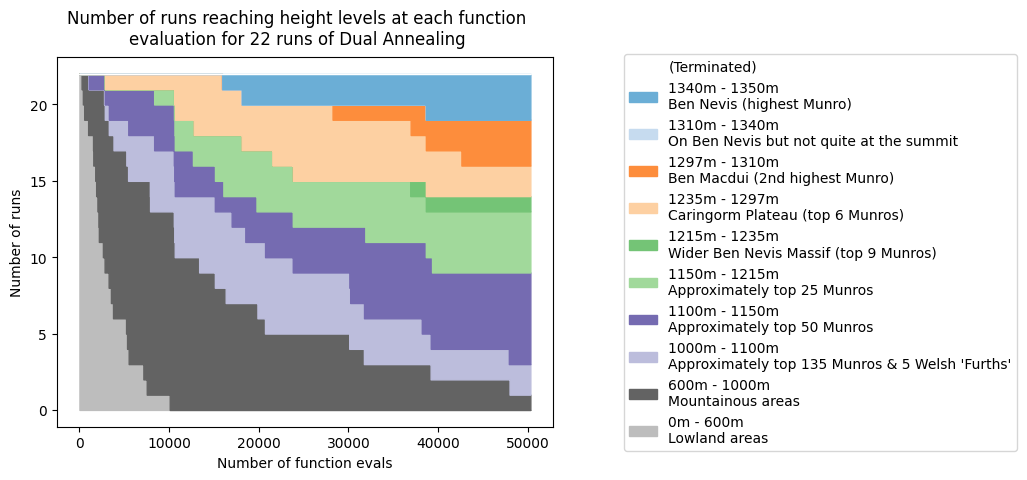

In [1]:
from algorithms import dual_annealing
from framework import *
import os

# make directories if they do not exist
if not os.path.exists('../result'):
    os.makedirs('../result')

if not os.path.exists('../result/json'):
    os.makedirs('../result/json')

# define a save handler
save_handler = SaveHandlerJSON('../result/json', 'test')
dual_annealing.tune_params(
    db_path='../result/3.db',
    iter_num=10, # just for test purposes, only 10 instances are generated
    save_handler=save_handler,
    plot_path='../result/',
)

During this tuning process we can use [optuna dashboard](https://optuna-dashboard.readthedocs.io/en/latest/getting-started.html) to see the performance of each instance (or trials, in the `optuna` context), by running 

```
optuna-dashboard sqlite:///../result/3.db
```

and then go to `http://127.0.0.1:8080/` to see the charts and data.

As you can see we have plotted the performance figures for all instances generated. We might want to disable this by passing `make_all_plots=False` to `tune_params`.

Now we can check the best instance selected from this hyper-parameter tuning process:

In [3]:
ins = dual_annealing.best_instance
ins.trial.params

{'initial_temp': 7291.680920444876,
 'restart_temp_ratio': 0.001085580709061958,
 'visit': 2.51512591056923,
 'accept': -3.854030312411809}

By default this instance hasn't been loaded with results, so we need to reload the results from the save handler:

In [4]:
ins.results

[]

In [5]:
ins.load_results(save_handler=save_handler)

In [6]:
ins.results

[{'algorithm_name': 'Dual Annealing', 'algorithm_version': 3, 'instance_index': 3, 'result_index': 0, 'ret_point': [216676.27240269515, 771271.7248406154], 'ret_height': 1345.0527619090465, 'message': 'Callback function requested to stop early by returning True', 'is_success': True, 'eval_num': 39, 'len_points': 73, 'gary_score': 10, 'info': {'algorithm_name': 'Dual Annealing', 'algorithm_version': 3, 'instance_index': 3, 'result_index': 0}},
 {'algorithm_name': 'Dual Annealing', 'algorithm_version': 3, 'instance_index': 3, 'result_index': 1, 'ret_point': [216677.1836890544, 771272.8833139387], 'ret_height': 1345.0996219003378, 'message': 'Callback function requested to stop early by returning True', 'is_success': True, 'eval_num': 23793, 'len_points': 23825, 'gary_score': 10, 'info': {'algorithm_name': 'Dual Annealing', 'algorithm_version': 3, 'instance_index': 3, 'result_index': 1}},
 {'algorithm_name': 'Dual Annealing', 'algorithm_version': 3, 'instance_index': 3, 'result_index': 2,

In [7]:
ins.performance_measures(excluding_first=True) # because the first run is always close to Ben Nevis

{'success_rate': 0.35714285714285715,
 'failure_rate': 0.6428571428571428,
 'success_cnt': 10,
 'avg_success_eval': 13638.0,
 'hv': 12986.428571428572,
 'par2': 69156.42857142857,
 'par10': 326299.28571428574,
 'avg_height': 1320.5919415611986,
 'ert': 103637.99999999999,
 'sp': 38186.4,
 'success_rate_upper': 0.5417002241777278,
 'success_rate_lower': 0.20705611972458873,
 'success_rate_length': 0.334644104453139,
 'gary_ert': 6818.289473684211}

Now `ins` is only partially loaded because it was partially saved in the hyper-parameter tuning. We won't be able to make a plot directly:

In [8]:
ins.plot_convergence_graph()

AssertionError: Results must be fully loaded.

To handle this, we simply rerun this instance. 

In [9]:
ins.run(
    save_handler=save_handler,
    restart=True, # we want to rerun everything, not starting from what we have saved now
    save_partial=False, # we do not want to save partial results
)

1036419it [00:49, 20847.55it/s]                            


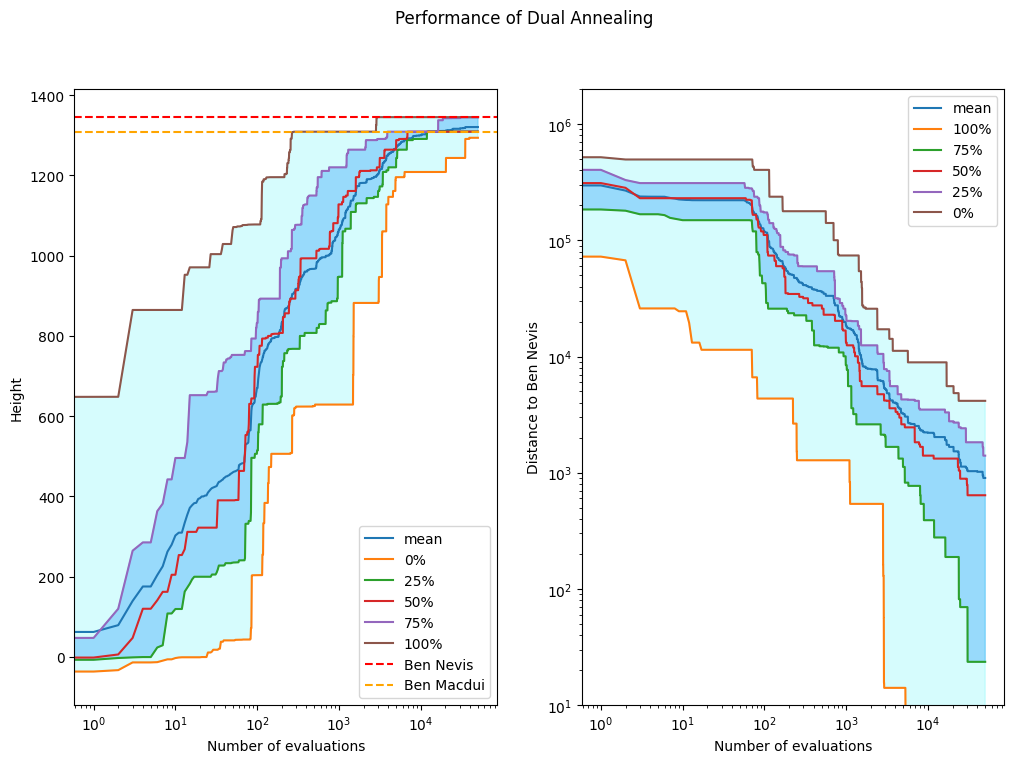

In [10]:
ins.plot_convergence_graph()

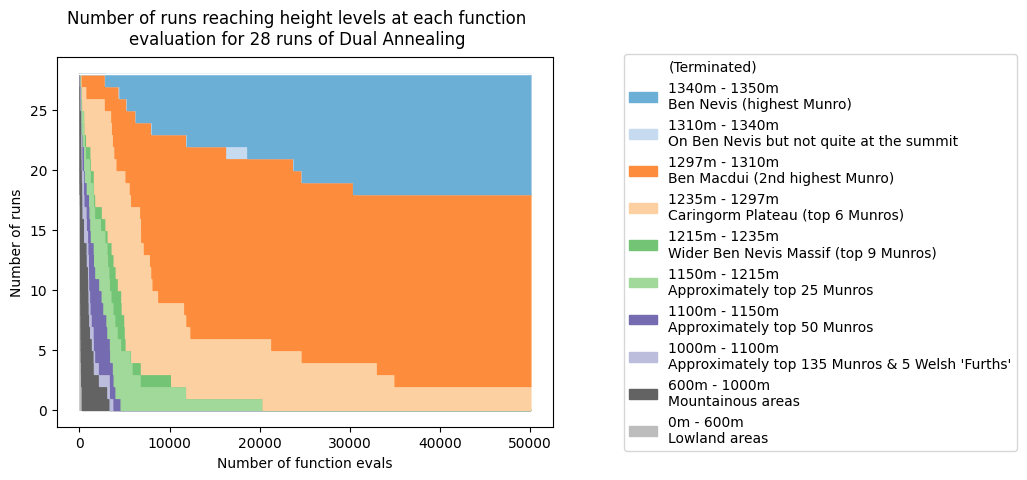

In [11]:
ins.plot_stacked_graph()

In plotting this stakced graph, we could select if we want the last value to be duplicated (default) or not:

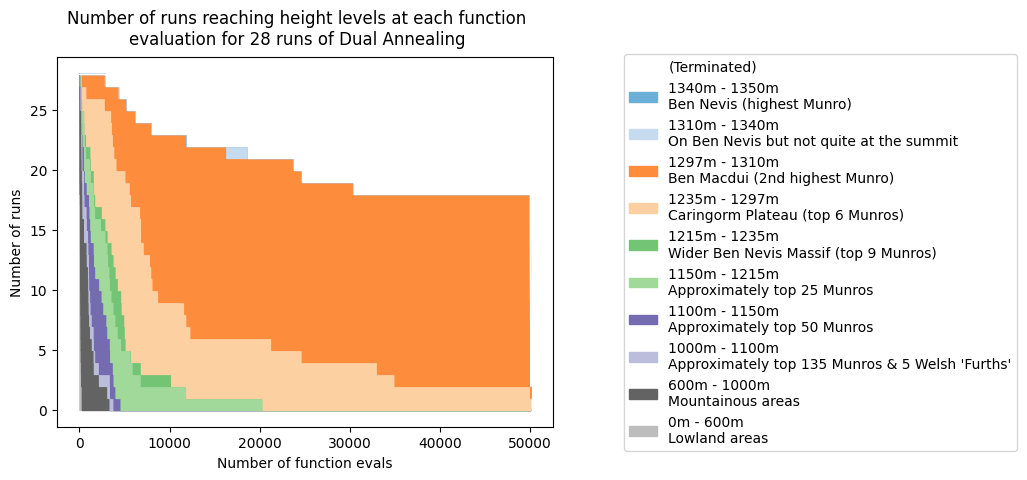

In [12]:
ins.plot_stacked_graph(mode='terminate')

## How to run hyper-parameter tuning concurrently

Please refer to [optuna documentation](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/004_distributed.html) for details.

An example is like this: create a Python script that calls the `tune-params` (we call it `run.py`):

```python
from algorithms import dual_annealing
from framework import SaveHandlerJSON

save_handler = SaveHandlerJSON('../result/json/')
algo = dual_annealing
algo.tune_params(
    db_path='../result/main.db',
    save_handler=save_handler,
    iter_num=40,
)
```

where `iter_num` should be set to the nubmer of algorithm instances generated by each process. Note that there should be no need to create a new study manually (i.e. use the `optuna create-study` command as said in the tutorial), because `tune_params` will create a new study if there isn't one and load the exsiting study if it finds the same study in the SQLite database at `db_path` (identified by the name and version of the current algorithm).

Now you can run this `run.py` in the terminal. You might start multiple terminals and run the script in each of them; or you can write a shell script that helps you with this. An example would be like this:

```bash
#!/usr/bin/env bash

source ../venv/bin/activate
for ((i = 1; i <= 5; i++)); do
  echo "Running iteration $i"
  python3 run.py &
done

wait $(jobs -p)
echo "All iterations finished!"
```

Clearly you should change the number of concurrent processes in the `for` loop above. In our case there will be 5 concurrent processes and each of them will generate 50 algorithm instances. They will share the study database at '../result/main.db', and as such, any iteration of any process will be able to utilise the data of all previous runs (carried out by all processes) and thus based on the study algorithm picks a new set of hyper-parameters to generate a new algorithm instance accordingly. 